# Laser Detection Algorithm on All Residuals
Run the laser detection algorithm on all stars, using absolute median noise to determine threshold

In [29]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
from random import uniform
import mplcursors
import pandas as pd
import glob
from operator import itemgetter

from astropy import stats
import astropy
%matplotlib inline

In [23]:
import csv

directory = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_all_apf/'

with open('/mnt_home/zoek/code/APF-BL-DAP/Zoe/Residual_file_list.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
list_of_files = []
for name in data[1:]:
    list_of_files += name
list_of_files = [directory + file for file in list_of_files]

## Necessary Functions
First two functions cpied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [24]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians by adding a gaussian into a given location in the spectrum
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect

# same as above, but REMOVES the part of the data where the gaussian is inserted
def insert_gaussian_with_data_removal(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

In [19]:
x = np.array([1, 2, 3])
np.std(x)

0.816496580927726

## Set parameters

In [32]:
plot = True  # plt.show()
save_figs = False  # save figures into folders

# for establishing threshold: how many sigmas to go above median
n = 30
plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams.update({'font.size': 7})

In [33]:
# detected signals information
detected_widths = []
detected_heights = []
detected_indicies = []
detected_wavelengths = []
detected_max_flux_vals = []

star_indicies = [] # which star in the list the other values correspond to
threshold_vals = []

num_injections = 0
num_injections_above_threshold = 0
num_recoveries = 0

# table containing all the stars and detections
column_names = ['star', 'index', 'ndetections']
total_detections = pd.DataFrame(columns = column_names)

## Read in Reduced Data from Anna Zuckerman's repo

In [34]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 19})

## Create folder to store all results

In [35]:
# create Laser Detection Results folder
if save_figs == True:
    path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/ResidualsLaserDetectionResults/'
    if not (os.path.isdir(path)):
        os.mkdir(path)

## Run algorithm on all stars in Anna's folder

In [36]:
# for which_star in np.arange(len(list_of_files)):
for which_star in np.arange(1):

    print(which_star)
    
    
    APF_flux_path = list_of_files[which_star]

    file = fits.open(APF_flux_path)

    flux = file[0].data
    residuals = file[1].data
    wl = file[2].data

    header = file[0].header
    star = header['OBJECT']
    print('Star: ' + star)
    
    
    # make a folder for this star
    if save_figs == True:
        path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/ResidualsLaserDetectionResults/' + str(which_star) + '_' + star
        if not (os.path.isdir(path)):
            os.mkdir(path)
        
    num_detections_this_star = 0
    # table containing info about this observation
    column_names = ['description', 'indicies']
    detections = pd.DataFrame(columns = column_names)

    spect = residuals

    idxs1 = [] # indicies that are above continuum level
    idxs2 = [] # indicies in idxs1 that are above the threshold value and are local maximas
    idxs3 = [] # indicies in idxs2 that are gaussian-shaped
    idxs4 = [] # indicies in idxs3 that are greater than 5 pixels in width


    
#     clipped = astropy.stats.sigma_clip(spect, sigma=5).filled()
#     abs_dev = stats.median_absolute_deviation(clipped)
#     med = np.median(clipped)

    abs_dev = stats.median_absolute_deviation(spect)
    med = np.median(spect)
    
    T = med + n * abs_dev
    threshold_vals = np.append(threshold_vals, T)
    
    for idx in np.arange(len(spect)):
        if spect[idx] > T:
            idxs2 = idxs2 + [idx]

    consecutive_indicies_idxs2 = []
    i = 0
    while i < (len(idxs2)):
        lst = [idxs2[i]]
        while (i < len(idxs2) - 1) and (idxs2[i + 1] == idxs2[i] + 1):
            lst = np.append(lst, idxs2[i+1])
            i += 1
        consecutive_indicies_idxs2 = consecutive_indicies_idxs2 + [lst]
        i +=1

    median_indicies = []
    for idxs in consecutive_indicies_idxs2:
        max_index = max(idxs, key=lambda i: spect[i])
        median_indicies = np.append(median_indicies, int(max_index))

    idxs2 = np.array(median_indicies, dtype=int)
    num_injections_above_threshold += len(idxs2)

    if (plot == True or save_figs == True):
        fig = plt.figure()
        plt.plot(wl, spect, label = 'Original Data')
        if (len(idxs2) > 0):
            for ind in idxs2:
                plt.axvline(x=wl[ind], color='gray', linestyle='--')
        plt.axhline(y=T, linestyle='--', label='Threshold')
        plt.title(star)
        plt.xlabel('Wavelength [A]')
        plt.ylabel('Flux')
        plt.legend() 
        if plot == True:
            plt.show()
        if save_figs == True:
            fig.savefig(path + '/' + star + 'data.png')


    for idx in idxs2:
        # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
        # see how much signal resembles a gaussian
        # if last test is commented out, ALSO check FWHM of gaussian

        # DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
        # PRO: can identify two signals together
        # CON: can't deal with noise in signal

        temp_ind = idx
        left_bound = 0
        while temp_ind > 1:
            temp_ind -= 1
            if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
                left_bound = temp_ind
                break
        temp_ind = idx
        right_bound = len(spect) - 1
        while temp_ind < len(spect) - 4:
            temp_ind += 1
            if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
                right_bound = temp_ind
                break

        x = wl[left_bound:right_bound + 2]
        y = spect[left_bound:right_bound + 2]

        # oversample detected signal to determine precise bounds on the edges of the signal
        # use this to determine the FWHM of the signal in pixels
        oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
        spl = splrep(x, y, k=2)
        oversampled_y = splev(oversampled_x, spl)

        max_y = max(oversampled_y)
        min_y = np.percentile(oversampled_y, 3) 
        height = max_y - min_y
        ind = oversampled_y.tolist().index(max_y)
        pos = oversampled_x[ind]
        min_width = 0.00001
        max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
        width_spacing = 0.001

        chi_squared_values = []
        width_vals = np.arange(min_width, max_width, width_spacing)
        for w in width_vals:
            gaus = gaussian(oversampled_x, height, pos, w, min_y)
            chi_squared = chi(gaus, oversampled_y)
            chi_squared_values = np.append(chi_squared_values, chi_squared)
        min_chi_squared = min(chi_squared_values)
        ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
        width = width_vals[ind_of_min_chisquared]
        gaus = gaussian(oversampled_x, height, pos, width, min_y)

        width_threshold = False
        gauss_threshold = False

        # see if the signal fits a gaussian
        if min_chi_squared < 11:
            gauss_threshold = True
            idxs3 = idxs3 + [idx]

            # find the width of the gaussian in pixels

            peak = max(gaus)
            half_max = peak - height / 2

            peak_index = gaus.tolist().index(peak)
            temp_left_bound = peak_index
            temp_right_bound = peak_index

            while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
                temp_left_bound -=1

            while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
                temp_right_bound += 1

            pixel_width = (temp_right_bound - temp_left_bound) / 10

            if pixel_width > 2.7:
                width_threshold = True
                idxs4 = idxs4 + [idx]
                num_detections_this_star += 1
        
        
        if plot == True or save_figs == True:
            fig = plt.figure()
            plt.step(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
            plt.plot(oversampled_x, gaus, label = 'Gaussian')
            if width_threshold == True:
                # passed width threshold AND gaussian threshold
                plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)) + ' and pixel width of ' + str(pixel_width))
            elif gauss_threshold == True and width_threshold == False:
                # failed width threshold
                plt.title('FAIL: too narrow with pixel width of ' + str(pixel_width))
            else:
                # failed gaussian threshold
                plt.title('FAIL: not gaussian-shaped: chi-squared of ' + str(round(min_chi_squared, 4)))

            plt.xlabel('Wavelength [A]')
            plt.ylabel('Flux')
            for ind in np.arange(left_bound, right_bound):
                plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
            plt.legend()
            if plot == True:
                plt.show()
            if save_figs == True:
                name = str(idx)
                fig.savefig(path + '/' + name + '.png')

    wavelengths = []
    for i in idxs4:
        w = wl[i]
        wavelengths += [w]

    new1 = {'description': ['indicies above threshold', 'indicies that are gaussian-shaped', 'indicies wider than PSF'],
            'indicies': [idxs2.tolist(), idxs3, idxs4], 'wavelengths': [[], [], wavelengths]}
    
    df1 = pd.DataFrame(new1)
    detections = detections.append(df1)
    name = str(which_star) + '_' + star
    if save_figs == True:
        detections.to_csv(path + '/' + name + '.csv')
    
    
    new2 = {'star': [star], 'index': [which_star], 'ndetections': [num_detections_this_star]}
    df2 = pd.DataFrame(new2)
    total_detections = total_detections.append(df2)

0
Star: HIP36439


TypeError: 'type' object is not iterable

## Save a table containing all the spectra and their number of detections

In [9]:
if save_figs == True:
    total_detections.to_csv('/home/zoek/code/APF-BL-DAP/Zoe/ResidualsLaserDetectionResults/results.csv')
else:
    print(total_detections)

## Results

In [30]:
total_df = pd.read_csv('/home/zoek/code/APF-BL-DAP/Zoe/10s-ResidualsResults/results.csv')

In [31]:
sum(total_df['ndetections'])

36

In [33]:
total_df[total_df['ndetections'] > 0]

,Unnamed: 0,star,index,ndetections
8,0,HIP64394,16,1
18,0,HIP104092,32,1
22,0,HIP13834,37,1
26,0,HIP80725,42,2
50,0,HIP110750,84,1
52,0,HIP81813,87,1
81,0,HIP71395,138,1
91,0,HIP29800,154,1
99,0,TIC255930614,164,2
102,0,HIP100017,168,1


In [15]:
total_df[total_df['ndetections'].between(1, 10)]

,Unnamed: 0,star,index,ndetections
1,0,HIP109980,1,2
2,0,TIC158025009,2,2
4,0,HIP4845,4,1
23,0,HIP64394,23,1
57,0,HIP13834,57,1
...,...,...,...,...
764,0,TYC2037-1484-1,764,1
765,0,TYC3010-1024-1,765,1
767,0,HIP56238,767,3
768,0,HIP69824,768,1


In [17]:
wls = []
all_indicies = []
i = 0

for name in glob.glob('/home/zoek/code/APF-BL-DAP/Zoe/ResidualsLaserDetectionResults/*/*.csv'):
    df = pd.read_csv(name)
    indicies = df.loc[2, 'indicies']
    
    name = name.split('/')[-1].split('_')[1].split('.')[0]
    fname = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_all_apf/' + name + '_NDRR.fits'
    if os.path.exists(fname):
        i += 1
        file = fits.open(fname)

        flux = file[0].data
        residuals = file[1].data
        wl = file[2].data

        if indicies != '[]':
            indicies = indicies.split('[')[1].split(']')[0].split(', ')
            for ind in indicies:
                all_indicies = np.append(all_indicies, int(ind))
                wls = np.append(wls, wl[int(ind)])

#     header = file[0].header
#     star = header['OBJECT']
    

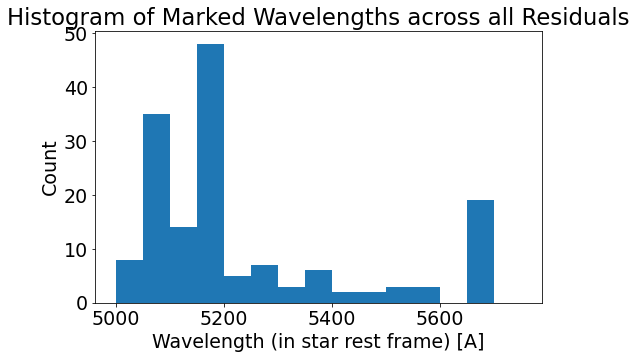

In [12]:
plt.hist(wls, bins = np.arange(5000, 5800, step = 50))
plt.xlabel('Wavelength (in star rest frame) [A]')
plt.ylabel('Count')
plt.title('Histogram of Marked Wavelengths across all Residuals')
plt.show()

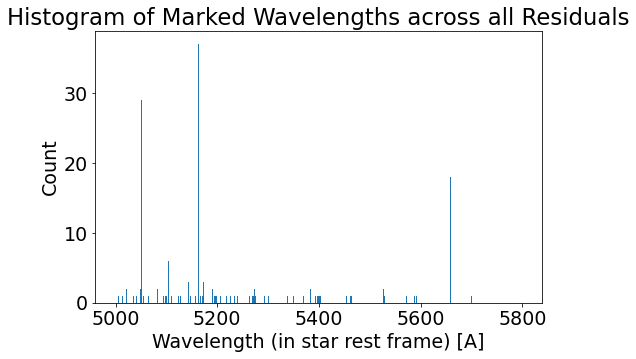

In [13]:
plt.hist(wls, bins = np.arange(5000, 5800, step = 2))
plt.xlabel('Wavelength (in star rest frame) [A]')
plt.ylabel('Count')
plt.title('Histogram of Marked Wavelengths across all Residuals')
plt.show()

In [14]:
# check to see if wavelength grids are same 

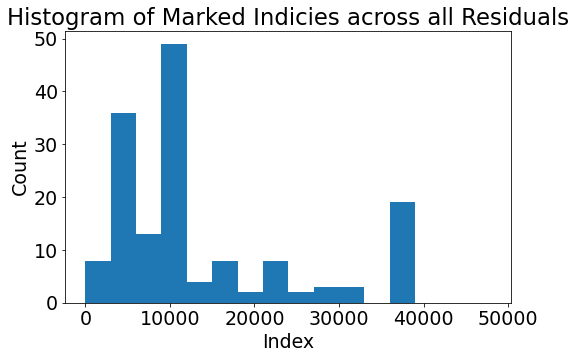

In [15]:
plt.hist(all_indicies, bins = np.arange(0, 50000, step = 3000))
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Histogram of Marked Indicies across all Residuals')
plt.show()

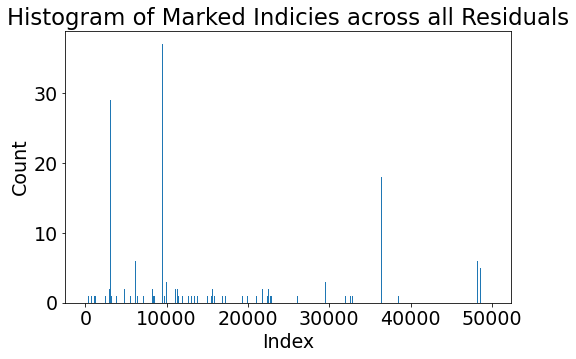

In [16]:
plt.hist(all_indicies, bins = np.arange(0, 50000, step = 100))
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Histogram of Marked Indicies across all Residuals')
plt.show()

In [17]:
num_detections = total_df['ndetections']

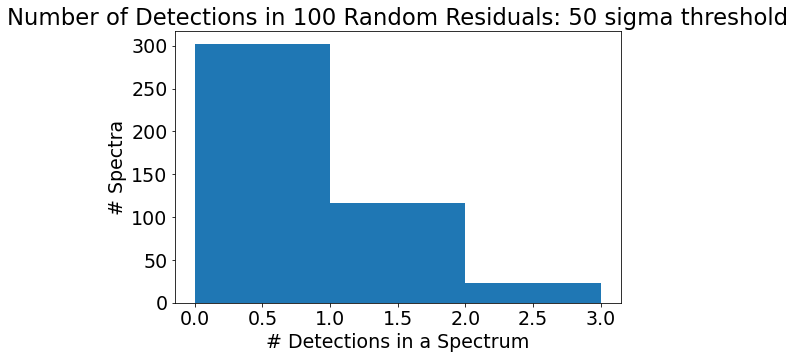

In [18]:
plt.hist(num_detections, bins=3)
plt.title('Number of Detections in 100 Random Residuals: 50 sigma threshold')
plt.xlabel('# Detections in a Spectrum')
plt.ylabel('# Spectra')
plt.show()

In [19]:
total_detections = sum(num_detections)
av_num_detections = np.average(num_detections)
median_num_detections = np.median(num_detections)

In [20]:
print('Total # Detections in ' + str(len(list_of_files)) + ' Residuals: ' + str(total_detections))
print('Mean # Detections per Spectrum: ' + str(av_num_detections))
print('Median # Detections per Spectrum: ' + str(median_num_detections))
print(str(sum(num_detections == 0)) + ' of these spectra have 0 detections')
print('Estimated Total # Detections in 5868 spectra: ' + str(int(av_num_detections * 5868)))

Total # Detections in 441 Residuals: 167
Mean # Detections per Spectrum: 0.3786848072562358
Median # Detections per Spectrum: 0.0
302 of these spectra have 0 detections
Estimated Total # Detections in 5868 spectra: 2222
